In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats
import os
import os.path

import scipy
from scikits import bootstrap as bootstrap
from collections import *
from scipy.interpolate import spline

from bs4 import BeautifulSoup
import urlparse
from urllib2 import urlopen
from urllib import urlretrieve
import urllib
import os
import sys
import re

from leven import levenshtein       
import numpy as np
from sklearn.cluster import dbscan

from fuzzywuzzy import fuzz
import textwrap

from scipy.stats import entropy
from numpy.linalg import norm


In [2]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2.0)

Note: The workshop alignments file is generated by code at the end of this notebook

In [3]:
workshop_to_prefixes = {}
prefix_to_workshop = {}

prefix_to_workshop_type = {}

with open('../resources/workshop-alignments.tsv') as f:
    for line in f:
        cols = line.strip().split('\t')
        prefices = set(cols[2:])
        if len(prefices) < 5:
            continue
        workshop_to_prefixes[cols[1]] = prefices
        if len(cols) >= 7:
            for p in cols[2:]:
                prefix_to_workshop[p] = cols[1]
                prefix_to_workshop_type[p] = 'Long-Running'

                
with open('../resources/workshop-alignments.tsv') as f:
    for line in f: 
        cols = line.strip().split('\t')
        name = cols[1]
        
        if re.search('[0-9]', name):
            continue
        lc = name.lower()
        if 'second' in lc or 'third' in lc or 'fourth' in lc or 'fifth' in lc or 'sixth' in lc or 'seventh' in lc:
            continue
        
        prefices = list(set(cols[2:]))
        # print len(prefices), prefices[0]
  
        if len(prefices) == 1 and prefices[0] not in prefix_to_workshop:
            prefix_to_workshop_type[prefices[0]] = 'One-off'
            prefix_to_workshop[prefices[0]] = name
            
print set(prefix_to_workshop_type.values())

set(['Long-Running', 'One-off'])


In [4]:
print workshop_to_prefixes['NODALIDA']
for w in workshop_to_prefixes['NODALIDA']:
    print prefix_to_workshop[w]

set(['W01-17', 'W15-18', 'W17-02', 'W05-17', 'W09-46', 'W11-46', 'W13-56', 'W98-16', 'W07-24', 'W91-03', 'W93-04', 'W99-10', 'W95-02'])
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA
NODALIDA


In [5]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [6]:
def awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None):

    def my_bootstrap(x):
        try:
            return bootstrap.ci(data=x, statfunction=scipy.mean, n_samples=n_samples)
        except:
            m = scipy.mean(x)
            return (m, m)

    
    # Pre-split into different columns
    cols = [ (None, big_df)]
    if col is not None:
        cols = []
        col_names = set(big_df[col])
        for cname in col_names:
            cols.append((cname, big_df[big_df[col] == cname]))
            
    for (col_name, col_df) in cols:
    
        hues_names = set(col_df[hue])
        attr_data = []
        fig1 = plt.figure()

        for hue_name in hues_names:
            df = col_df[col_df[hue] == hue_name]

            # Get the actual mean at each year
            y1_mean = df.groupby([x], as_index=False)[y].mean()
            y1_cis = df.groupby([x], as_index=False)[y].apply(lambda x:my_bootstrap(x))
            #print y1_cis
            attr_data.append((y1_mean, y1_cis, hue_name))
            
        # EWM = Exponentially-Weighted Mean, which is what we use for smooth.  Set this to 1 for no smoothing
        ewm_span = smoothing

        # Get the upper and lower bound for the confidence intervals
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            EwmAcc = attr_mean[y].ewm(span=ewm_span).mean()
            
            upper_bound = []
            lower_bound = []
            eb_df_data = {'Upper Bound': upper_bound, 'Lower Bound': lower_bound}
    
            for i in range(0, len(attr_cis)):
                lower_bound.append(attr_cis[i][0])
                upper_bound.append(attr_cis[i][1])

            eb_df = pd.DataFrame(eb_df_data, columns = ['Upper Bound', 'Lower Bound'])
            attr_mean['Ewm Mean'] = EwmAcc
            attr_mean['Ewm UB'] = eb_df['Upper Bound'].ewm(span=ewm_span).mean()
            attr_mean['Ewm LB'] = eb_df['Lower Bound'].ewm(span=ewm_span).mean()
            
            #print attr_mean.head(100)
            
        colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']        
        styles = ['-', '--', '-.', ':', '-']
        for j, (attr_mean, attr_cis, attr_name) in enumerate(attr_data):
            # print col_name, attr_name
 
            label = attr_name
            if relabeling is not None:
                if label in relabeling:
                    label = relabeling[label]

            plt.plot(attr_mean[x], attr_mean['Ewm Mean'], \
                     label=label, color=colors[j % len(colors)], ls=styles[j % len(styles)])
        
            plt.fill_between(attr_mean[x], attr_mean['Ewm LB'], attr_mean['Ewm UB'], \
                             interpolate=False, alpha=0.1, edgecolor=None, \
                             color=colors[j % len(colors)])
    
        plt.legend(ncol=1, fontsize=14, loc='upper left', bbox_to_anchor=(1., 0.8))
        plt.gca().set_axis_bgcolor('white')
        if col_name is not None:
            plt.suptitle(col + ' = ' + str(col_name))


        ax = plt.gca()
        # 'Reproductive Success Rate\n(what % of graduates have children)'
        ax.set_ylabel(ylabel, fontsize=22)
        ax.set_xlabel(xlabel, fontsize=22)  
        ax.grid(False)
        plt.tight_layout()   

In [7]:
def percent_sample_awesome_plot(big_df, x, y, hue, col=None, smoothing=1, n_samples=10000, xlabel='', ylabel='', relabeling=None):
    hues = set(big_df[hue])

    grouped = big_df.groupby(x)
    df_for_plot = []
    for x_val, group in grouped:
        raw_counts = []
        # print x_val, group[[hue, y]]
        for row in group[[hue, y]].itertuples():
            hue_name = row[1]
            # Generate a long list of how many times this particular hue occurred
            for i in range(row[2]):
                raw_counts.append(hue_name)

        # Sample from the total counts to bootstrap the percentages of how many times each hue occurs
        n = len(raw_counts)
        nf = float(n)
        hue_to_probs = defaultdict(list)
        for i in range(n_samples):
            sample = np.random.choice(raw_counts, n)
            counts = Counter(sample)
            for h in hues:
                hue_to_probs[h].append(counts[h] / nf)
        
        # print hue_to_probs
        for h, probs in hue_to_probs.iteritems():
            bleh = {}
            df_for_plot.append(bleh)

            probs.sort()
            bleh['X'] = x_val
            bleh['Hue'] = h
            bleh['Mean'] = probs[len(probs)/2]
            bleh['Upper Bound'] = probs[(19*len(probs))/20] # 95%
            bleh['Lower Bound'] = probs[len(probs)/20]  # 5%
    df_for_plot = pd.DataFrame(df_for_plot)
    
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']        
    styles = ['-', '--', '-.', ':', '-']
    for j, h in enumerate(hues):
        sub_df = df_for_plot[df_for_plot['Hue'] == h]
        xs = sub_df['X']

        attr_mean = sub_df['Mean']
        
        #print h, attr_mean
        
        lower_bound = sub_df['Lower Bound']
        upper_bound = sub_df['Upper Bound']

        label = h
        if relabeling is not None:
            if label in relabeling:
                label = relabeling[label]

        plt.plot(xs, attr_mean, \
                label=label, color=colors[j % len(colors)], ls=styles[j % len(styles)])
        
        plt.fill_between(xs, lower_bound, upper_bound, \
                         interpolate=False, alpha=0.1, edgecolor=None, \
                         color=colors[j % len(colors)])
    
    plt.legend(ncol=1, fontsize=14, loc='upper left', bbox_to_anchor=(1., 0.8))
    plt.gca().set_axis_bgcolor('white')

    ax = plt.gca()
    ax.set_ylabel(ylabel, fontsize=22)
    ax.set_xlabel(xlabel, fontsize=22)  
    ax.grid(False)
    plt.tight_layout()   

In [8]:
def bootstrap_percentages(big_df, x, y, hue, n_samples=10000):
    hues = set(big_df[hue])

    grouped = big_df.groupby(x)
    df_for_plot = []
    for x_val, group in grouped:
        raw_counts = []
        # print x_val, group[[hue, y]]
        for row in group[[hue, y]].itertuples():
            hue_name = row[1]
            # Generate a long list of how many times this particular hue occurred
            for i in range(row[2]):
                raw_counts.append(hue_name)

        # Sample from the total counts to bootstrap the percentages of how many times each hue occurs
        n = len(raw_counts)
        nf = float(n)
        hue_to_probs = defaultdict(list)
        for i in range(n_samples):
            sample = np.random.choice(raw_counts, n)
            counts = Counter(sample)
            for h in hues:
                hue_to_probs[h].append(counts[h] / nf)
        
        # print hue_to_probs
        for h, probs in hue_to_probs.iteritems():
            bleh = {}
            df_for_plot.append(bleh)

            probs.sort()
            bleh[x] = x_val
            bleh[hue] = h
            bleh['probability'] = probs[len(probs)/2]
            bleh['Upper Bound'] = probs[(19*len(probs))/20] # 95%
            bleh['Lower Bound'] = probs[len(probs)/20]  # 5%
    df_for_plot = pd.DataFrame(df_for_plot)
    return df_for_plot

In [7]:
percent_sample_awesome_plot(acl_df, 'year', 'count', 'citation function', n_samples=100)

NameError: name 'acl_df' is not defined

In [46]:
citing_to_typed_cited = defaultdict(set)
cited_to_citing = defaultdict(set)
cited_to_typed_citing = defaultdict(set)


#with open('../results/citation-graph/global-weights/cite-func.global-weights.tmp.tsv') as f:

with open('../results/acl-arc.citation-graph.with-functions.tsv') as f:    
    
    for line in f: 
        cols = line[:-1].split('\t')
        citing = cols[0][:8]
        cited = cols[1]
        function = cols[4]
        citing_to_typed_cited[citing].add((cited, function))
        
        if 'xternal' not in cited:
            cited_to_citing[cited].add(citing)
            cited_to_typed_citing[cited].add((citing, function))

In [47]:
all_papers = [x for x in set(citing_to_typed_cited.iterkeys()) | set(cited_to_citing.iterkeys()) if not 'xtern' in x]
paper_to_year = {}
for p in all_papers:
    y = int(p[1:3])
    if y < 50:
        y += 2000
    else:
        y += 1900
    paper_to_year[p] = y

In [48]:
how_citing_df = []
how_citing_counter = Counter()
how_citing_sum_counter = Counter()

for citing, typed_cited in citing_to_typed_cited.iteritems():    
    citing_year = paper_to_year[citing]
    venue = citing[0]
    
    for tc in typed_cited:
        func = tc[1]
        how_citing_counter[(venue, func, citing_year)] += 1
        how_citing_sum_counter[(venue, citing_year)] += 1
        
for (venue, func, citing_year), count in how_citing_counter.iteritems():
        how_citing_df.append({
            'venue': venue,
            'citation function': func,
            'year': citing_year,
            'count': count,
            'percentage': float(count) / how_citing_sum_counter[(venue, citing_year)],
        })

how_citing_df = pd.DataFrame(how_citing_df)        

In [49]:
workshop_how_citing_df = []
workshop_how_citing_counter = Counter()
workshop_how_citing_sum_counter = Counter()

funcs = set()
workshop_to_years = defaultdict(list)

for ci, (citing, typed_cited) in enumerate(citing_to_typed_cited.iteritems()):    
    citing_year = paper_to_year[citing]
    venue_prefix = citing[0:6]
    while len(venue_prefix) > 2:
        if venue_prefix not in prefix_to_workshop:
            venue_prefix = venue_prefix[:len(venue_prefix)-1]
        else:
            break
    if len(venue_prefix) == 2:
        continue

    for tc in typed_cited:
        workshop = prefix_to_workshop[venue_prefix]
        wtype =  prefix_to_workshop_type[venue_prefix]
        # print workshop
        func = tc[1]
        funcs.add(func)
        workshop_to_years[(workshop, wtype)].append(citing_year)
        workshop_how_citing_counter[(workshop, func, citing_year)] += 1
        workshop_how_citing_sum_counter[(workshop, citing_year)] += 1
    #if ci > 100:
    #    break
for (workshop, wtype), years in workshop_to_years.iteritems():
    for citing_year in range(min(years), max(years)+1):
        
        # Check the workshop occurred that year
        tmp_sum = 0
        for func in funcs:
            tmp_sum += workshop_how_citing_counter[(workshop, func, citing_year)]
        if tmp_sum == 0:
            continue
        
        for func in funcs:
            count = workshop_how_citing_counter[(workshop, func, citing_year)]
            perc = 0
            csum = workshop_how_citing_sum_counter[(workshop, citing_year)]
            if csum > 0:
                perc = float(count) / csum
            workshop_how_citing_df.append({
                    'workshop': workshop,
                    'citation function': func,
                    'year': citing_year,
                    'count': count,
                    'percentage': perc,
                    'type': wtype,
            })

full_workshop_how_citing_df = pd.DataFrame(workshop_how_citing_df)
print set(full_workshop_how_citing_df['type'])
workshop_how_citing_df = full_workshop_how_citing_df[full_workshop_how_citing_df['type'] == 'Long-Running']

set(['Long-Running', 'One-off'])


In [13]:
# Get the IJCNLP Data
workshop_how_citing_df[workshop_how_citing_df['workshop'] == 'NODALIDA']

,citation function,count,percentage,type,workshop,year
2676,Motivation,63,0.110333,Long-Running,NODALIDA,2015
2677,Future,47,0.082312,Long-Running,NODALIDA,2015
2678,Uses,196,0.343257,Long-Running,NODALIDA,2015
2679,Background,194,0.339755,Long-Running,NODALIDA,2015
2680,Extends,15,0.026270,Long-Running,NODALIDA,2015
2681,CompareOrContrast,56,0.098074,Long-Running,NODALIDA,2015


In [14]:
ijcnlp_df = how_citing_df[(how_citing_df['venue'] == 'I')]
print len(ijcnlp_df)


0


# Figure out how often each citation type appears per year in the two main conference

In [50]:
confs_df = how_citing_df[(how_citing_df['venue'] == 'P') | (how_citing_df['venue'] == 'N')]
yearly_cite_type_percs_in_confs = bootstrap_percentages(confs_df, 'year', 'count', 'citation function', n_samples=100)
yearly_cite_type_percs_in_confs.head()

,Lower Bound,Upper Bound,citation function,probability,year
0,0.000000,0.039216,Motivation,0.019608,1979
1,0.019608,0.117647,Future,0.058824,1979
2,0.000000,0.000000,Extends,0.000000,1979
3,0.254902,0.450980,Background,0.352941,1979
4,0.176471,0.352941,Uses,0.254902,1979


In [51]:
workshops = set(full_workshop_how_citing_df['workshop'])
#workshops = ['Reordering for Statistical Machine Translation']

functions = set(how_citing_df['citation function'])

workshop_transition_df = []

for w in workshops:
    # print w
    try:
        w = w.encode('ascii')
    except:
        continue
    w_df = full_workshop_how_citing_df[full_workshop_how_citing_df['workshop'] == w]
    if len(w_df) < 1:
        print 'no data for', w
        continue
    wtype = list(set(w_df['type']))[0]
    #print w_df.columns
    yearly_cite_type_percs_in_w = bootstrap_percentages(w_df, 'year', 'count', 'citation function', n_samples=100)
    yearly_groups = yearly_cite_type_percs_in_w.groupby('year')
    
    
    for year, group in yearly_groups:
        raw_counts = []
        conf_percs = yearly_cite_type_percs_in_confs[yearly_cite_type_percs_in_confs['year'] == year]
        # print conf_percs

        conf_dict = Counter()
        w_dict = Counter()
        
        # print x_val, group[[hue, y]]
        for row in group[['citation function', 'probability']].itertuples():
            func = row[1]
            workshop_perc = row[2]
            conf_perc = conf_percs[conf_percs['citation function'] == func]['probability']
            # print year, func, float(workshop_perc), float(conf_perc)
            conf_dict[func] = float(conf_perc)
            w_dict[func] = float(workshop_perc)
            
        conf_vec = []
        w_vec = []
        for func in functions:
            conf_vec.append(conf_dict[func])
            w_vec.append(w_dict[func])
        conf_vec = np.array(conf_vec)
        w_vec = np.array(w_vec)
        #sim = 1 - JSD(conf_vec, w_vec)
        sim = 1 - scipy.spatial.distance.cosine(conf_vec, w_vec)
        
        workshop_transition_df.append({'year': year, 'workshop': w, 
                                       'similarity': sim, 'type': wtype})
    # break
    
full_workshop_transition_df = pd.DataFrame(workshop_transition_df)
workshop_transition_df = full_workshop_transition_df[full_workshop_transition_df['type'] == 'Long-Running']

In [52]:
set(full_workshop_transition_df['type'])

{'Long-Running', 'One-off'}

/Users/jurgens/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


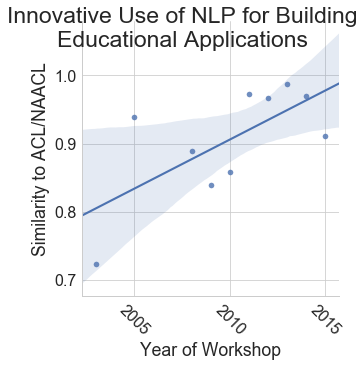

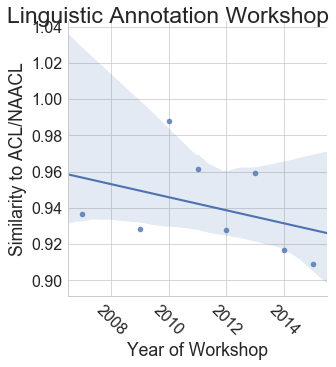

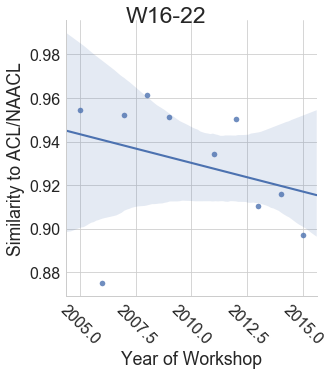

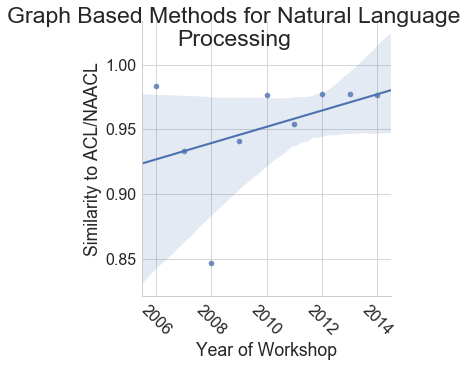

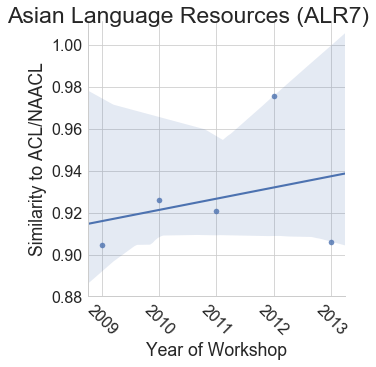

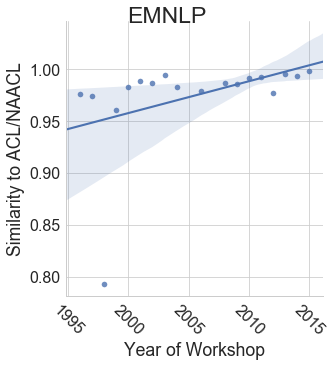

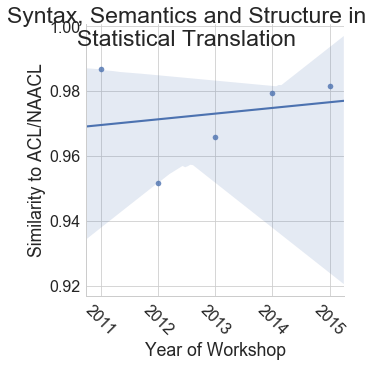

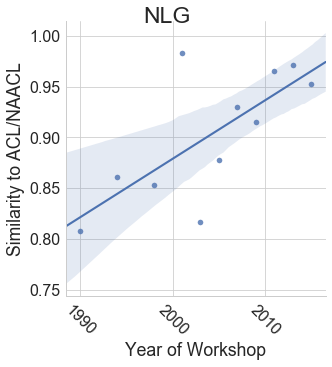

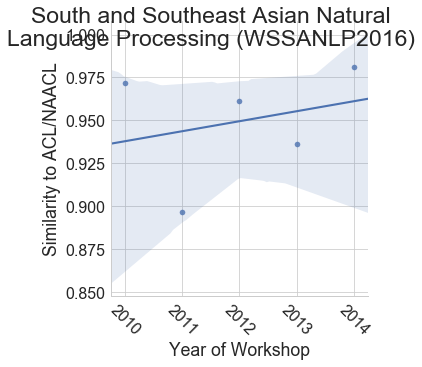

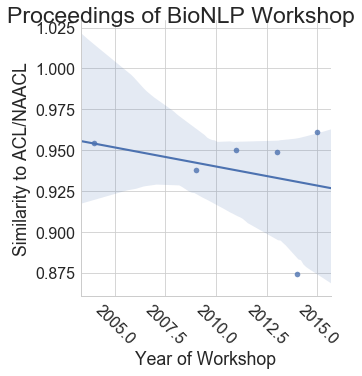

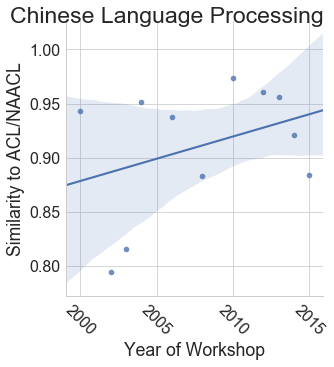

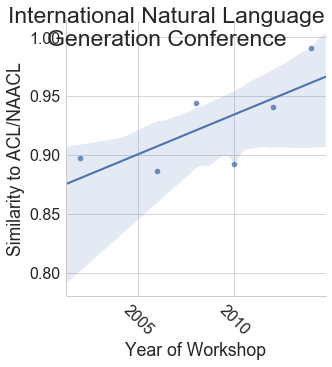

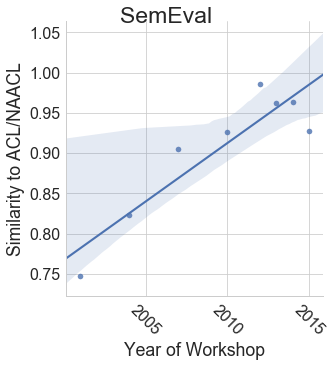

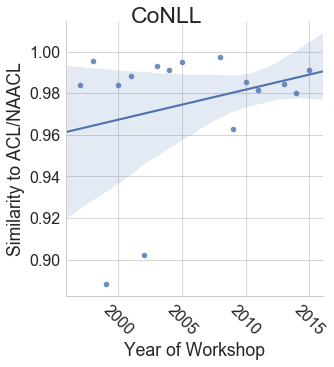

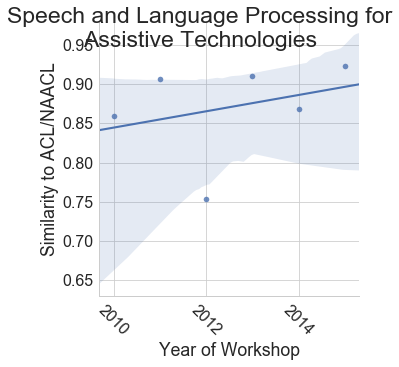

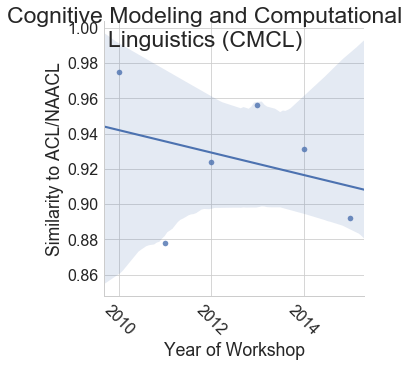

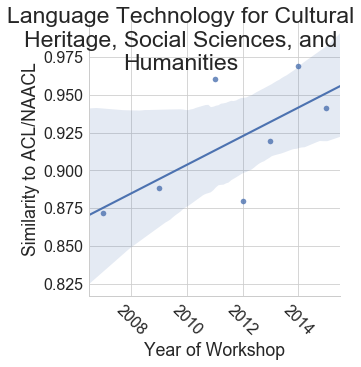

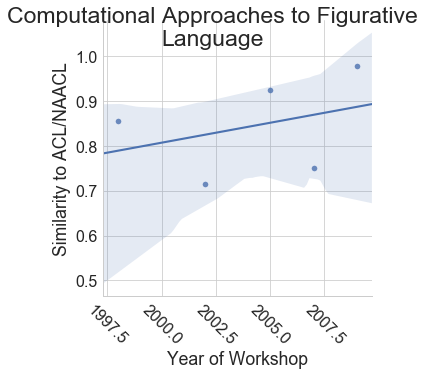

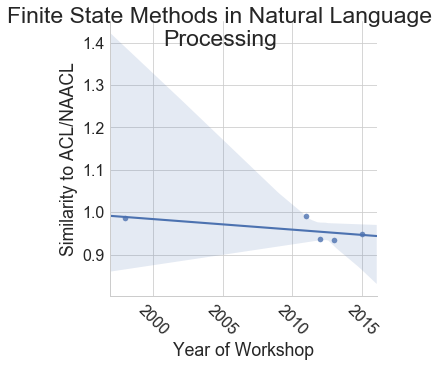

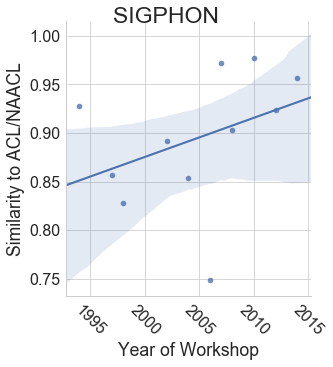

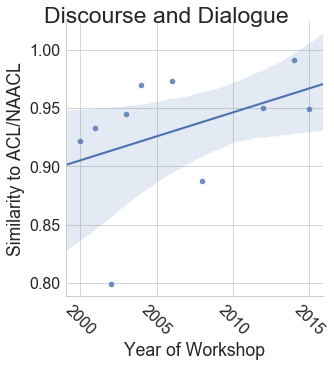

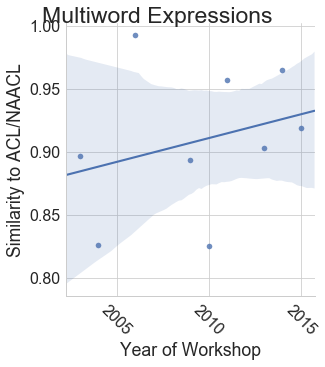

In [23]:
workshop_transition_df.head()
workshops = set(workshop_transition_df['workshop'])
#workshops = ['Reordering for Statistical Machine Translation']

for w in workshops:
    # break
    w_df = workshop_transition_df[workshop_transition_df['workshop'] == w]
    if len(w_df) < 5:
        continue
    g = sns.lmplot(x="year", y="similarity", robust=False, data=w_df)
    g.fig.suptitle(textwrap.fill(w, 40).decode('utf-8'))
    g.set_xticklabels(rotation=-45)
    g.set(xlabel='Year of Workshop', ylabel='Similarity to ACL/NAACL')

    #g.fig.set_ylabel('')
    # plt.ylim(-0.02, 1.02)
    #break    

226


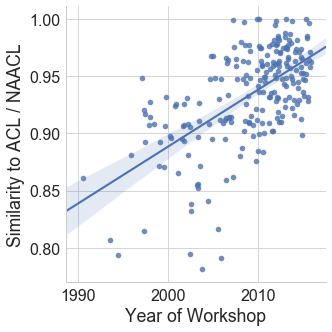

In [121]:
lrw_tmp = full_workshop_transition_df[full_workshop_transition_df['type'] == 'Long-Running']
print len(lrw_tmp)
g = sns.lmplot(x="year", y="similarity", x_jitter=True, legend_out=False, 
               robust=False, data=lrw_tmp)
# g.set_xticklabels(rotation=-45)
g.set(xlabel='Year of Workshop', ylabel='Similarity to ACL / NAACL')
#g.savefig('workshop.similarity-change.pdf')

In [18]:
full_workshop_transition_df[full_workshop_transition_df['workshop'] == 'EMNLP'].head()

,similarity,type,workshop,year
422,0.976257,Long-Running,EMNLP,1996
423,0.974855,Long-Running,EMNLP,1997
424,0.793512,Long-Running,EMNLP,1998
425,0.960639,Long-Running,EMNLP,1999
426,0.982677,Long-Running,EMNLP,2000


469


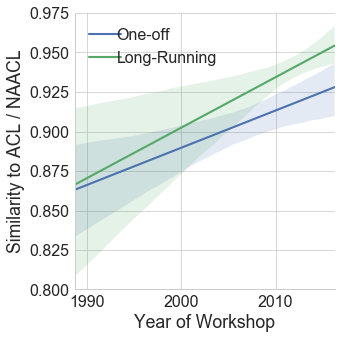

In [62]:
not_w_df = full_workshop_transition_df[(full_workshop_transition_df['workshop'] != 'EMNLP') 
                                         & (full_workshop_transition_df['workshop'] != 'CoNLL')]
print len(not_w_df)                      

g = sns.lmplot(x="year", y="similarity", hue='type', x_jitter=True, legend=False, 
               robust=True, data=not_w_df, markers=['o', 'x'], scatter=False)
# g.set_xticklabels(rotation=-45)
plt.legend(loc='best', handletextpad=-0.3)
g.set(xlabel='Year of Workshop', ylabel='Similarity to ACL / NAACL')
g.savefig('workshop.similarity-change.pdf')

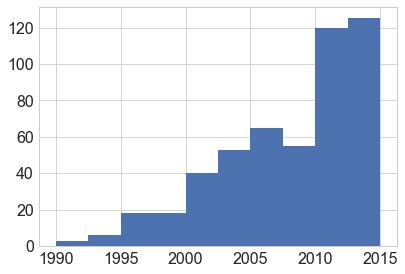

In [20]:
full_workshop_transition_df['year'].hist()

In [21]:
print workshop_transition_df[workshop_transition_df['workshop'] == 'NODALIDA']

    similarity          type  workshop  year
77    0.952319  Long-Running  NODALIDA  2015


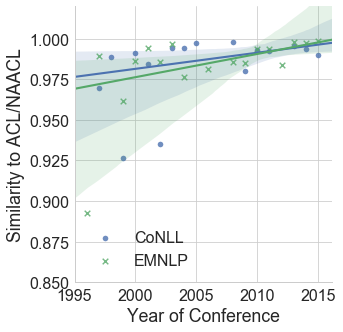

In [54]:
w_df = workshop_transition_df[(workshop_transition_df['workshop'] == 'EMNLP') 
                              | (workshop_transition_df['workshop'] == 'CoNLL')
                            ]
g = sns.lmplot(x="year", y="similarity", robust=True, data=w_df, 
               hue='workshop', legend=False, markers=['o', 'x'], truncate=False)
g.set(xlabel='Year of Conference', ylabel='Similarity to ACL/NAACL')
plt.legend(loc='best')
plt.ylim(0.85, 1.020)
g.savefig('emnlp.similarity-change.pdf')

In [97]:
full_workshop_transition_df[(full_workshop_transition_df['year']==2005) & (full_workshop_transition_df['type']=='One-off')]

,similarity,type,workshop,year
208,0.86964,One-off,Psychocomputational Models of Human Language A...,2005


In [111]:
print len(full_workshop_transition_df[(full_workshop_transition_df['type']=='One-off')])

277


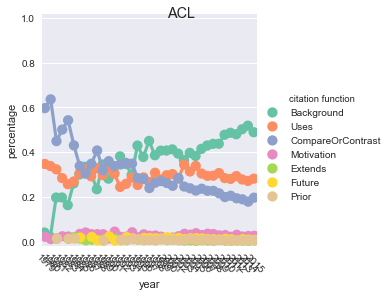

In [28]:
custom_venues = ['P', 'N', 'J']
#workshops = ['Reordering for Statistical Machine Translation']

name_map = {'P': "ACL", 'N': "NAACL", 'J': 'J. of Comp. Ling.'}

for venue in custom_venues:
    w_df = how_citing_df[how_citing_df['venue'] == venue]
    #print w_df.head()
    g = sns.factorplot(x="year", y="percentage", title=w, data=w_df, ci=None, 
                       hue_order=['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future', 'Prior'],
                       hue='citation function', dodge=True, palette='Set2')
    g.fig.suptitle(name_map[venue])
    g.set_xticklabels(rotation=-45)
    plt.ylim(-0.02, 1.02)
    break

In [29]:
acl_df = w_df

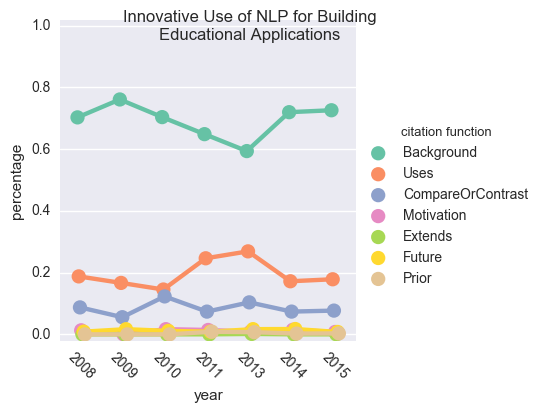

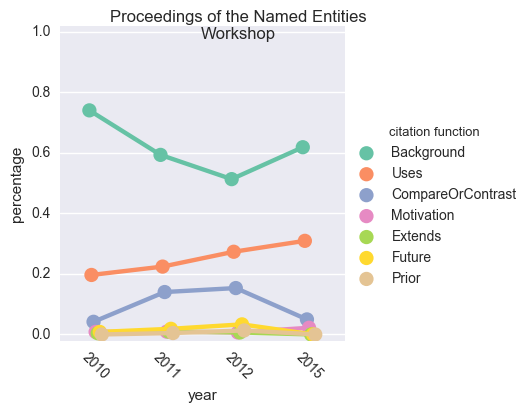

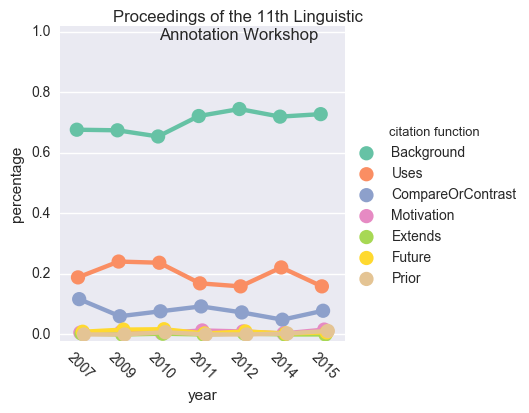

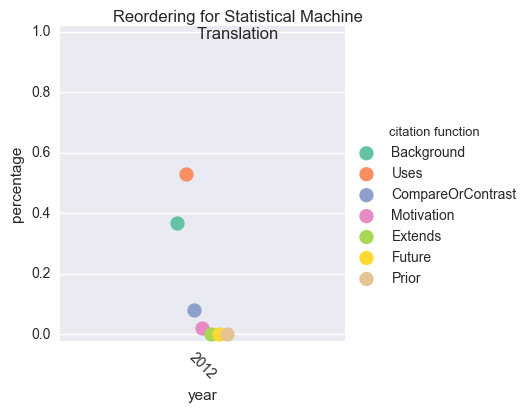

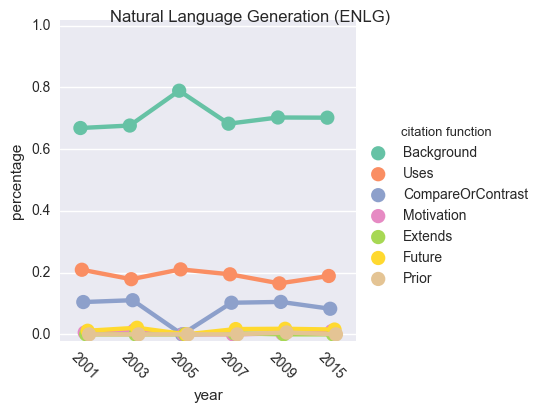

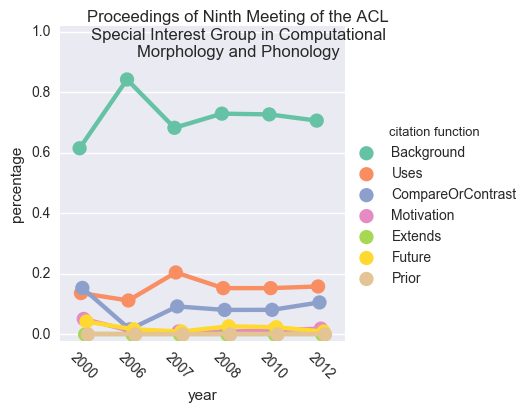

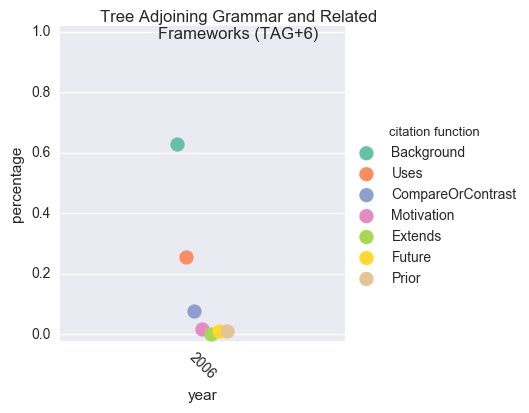

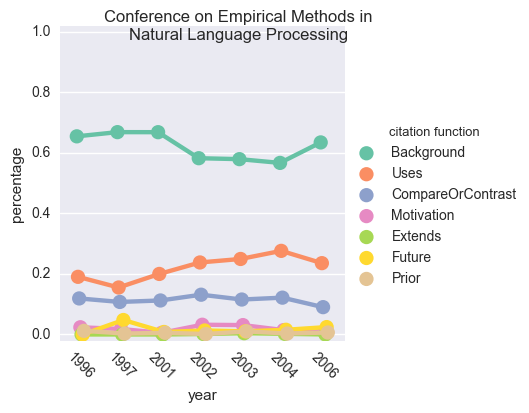

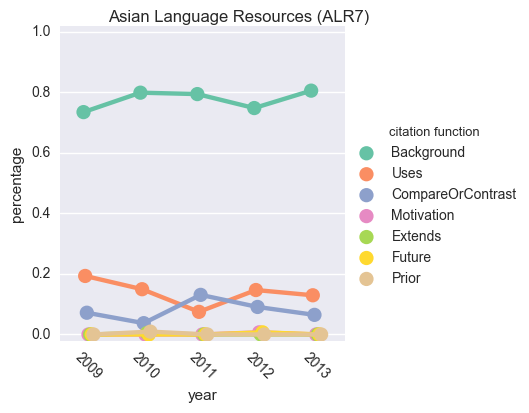

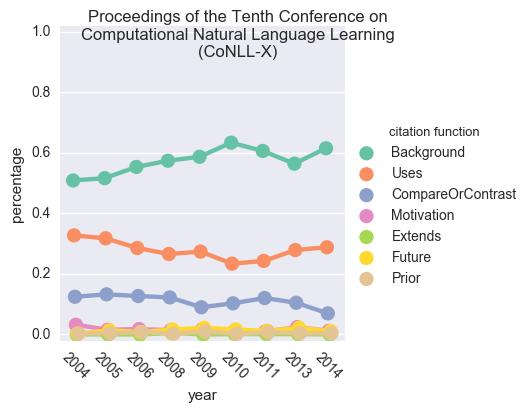

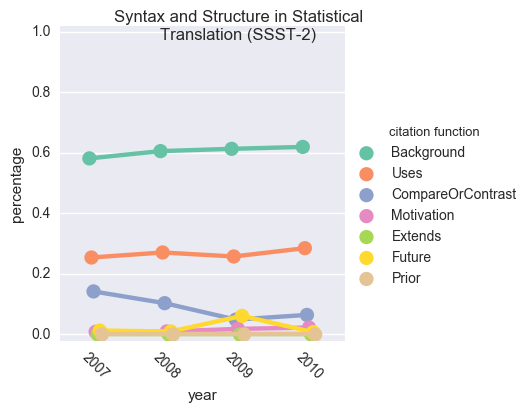

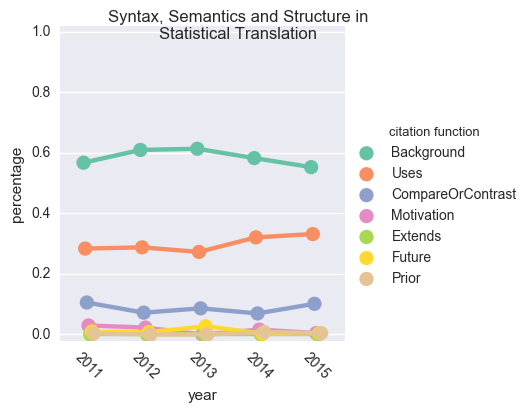

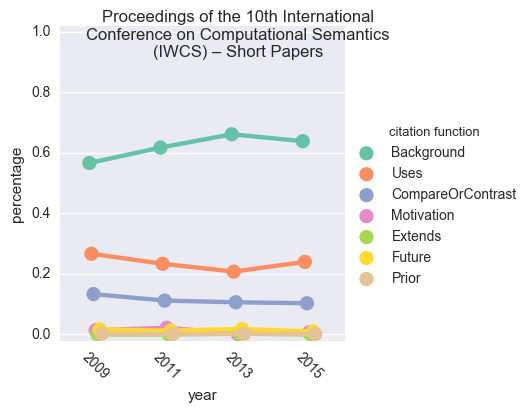

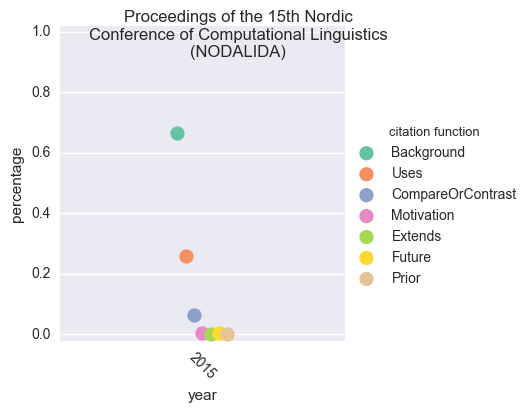

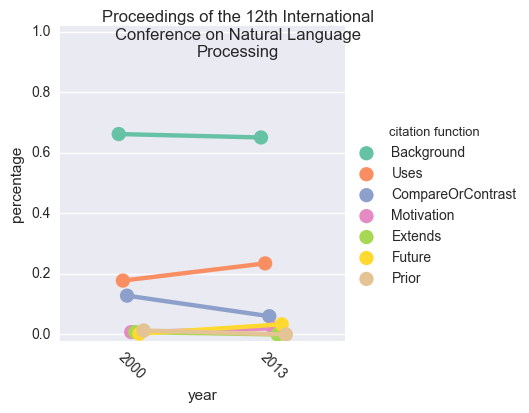

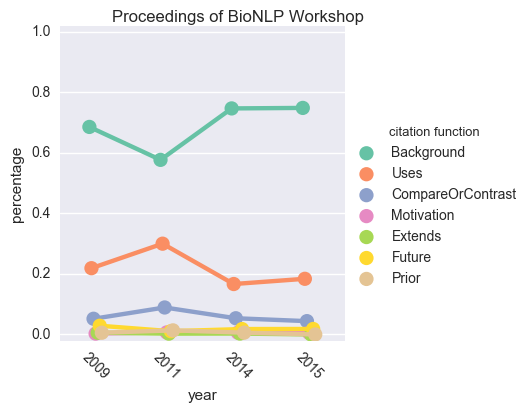

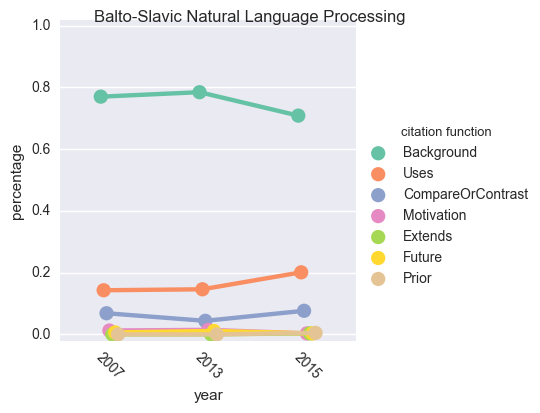

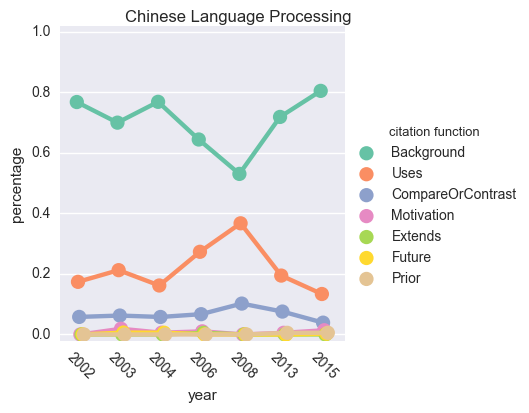

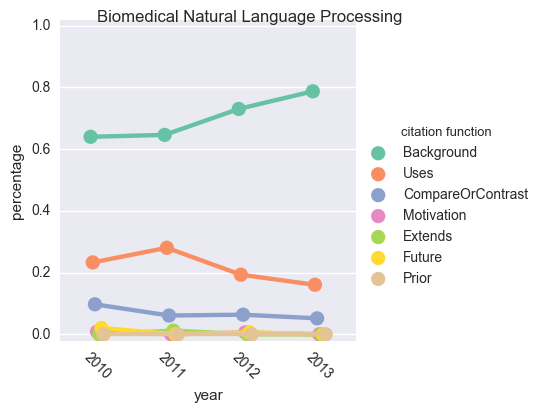

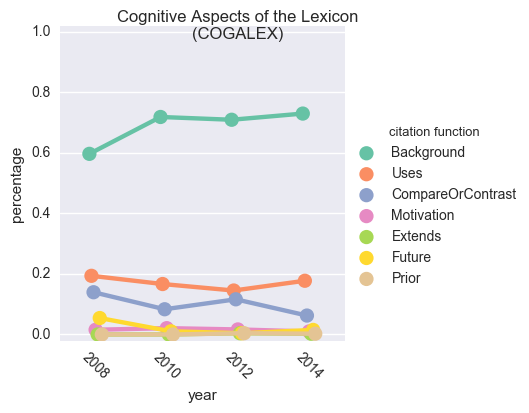

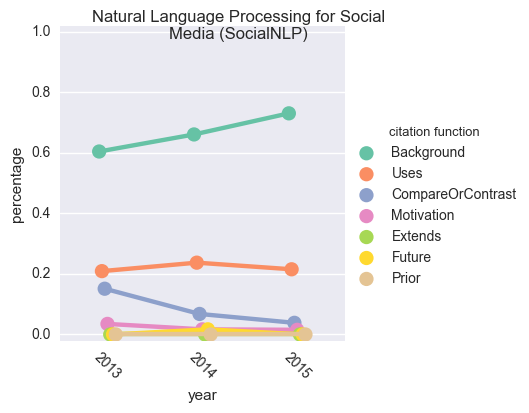

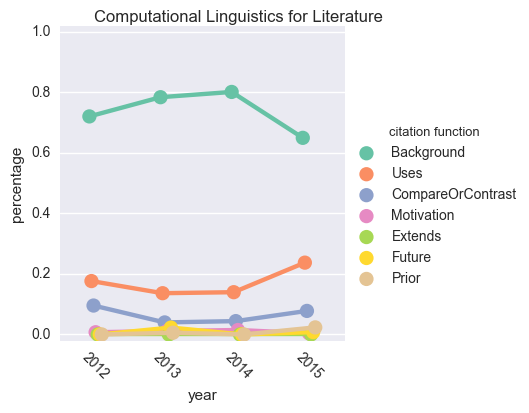

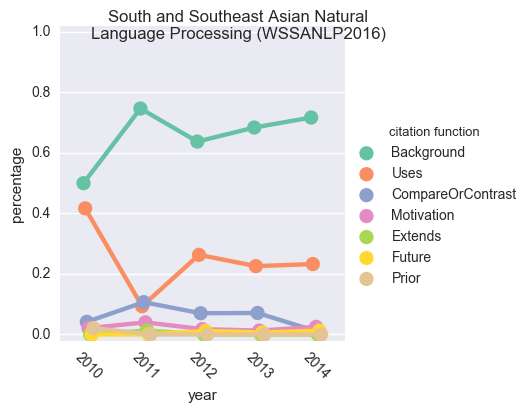

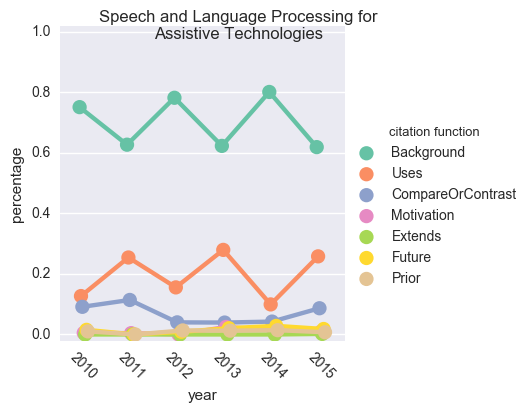

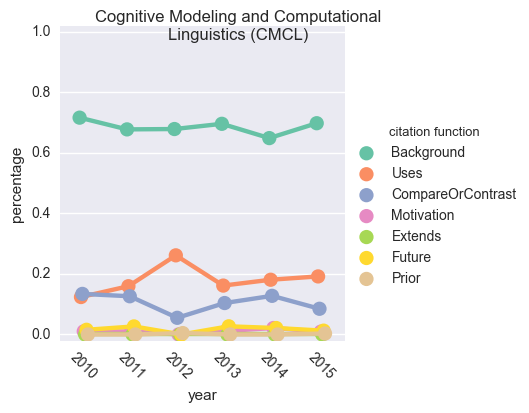

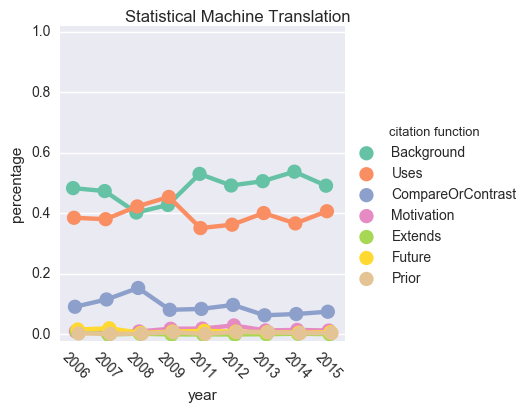

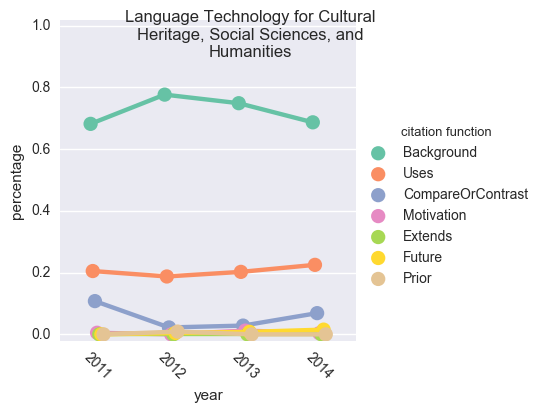

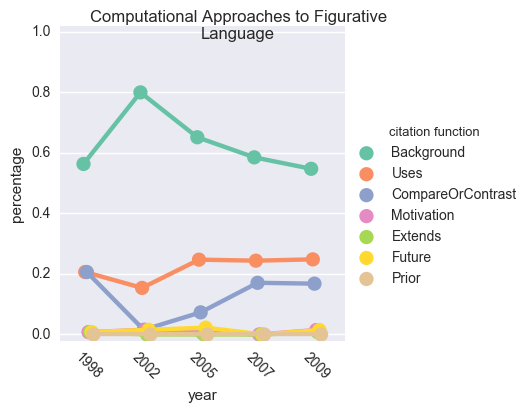

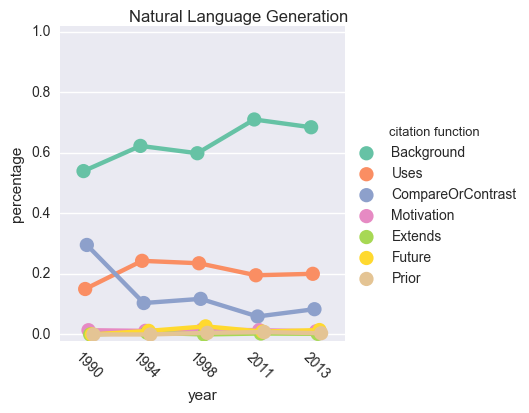

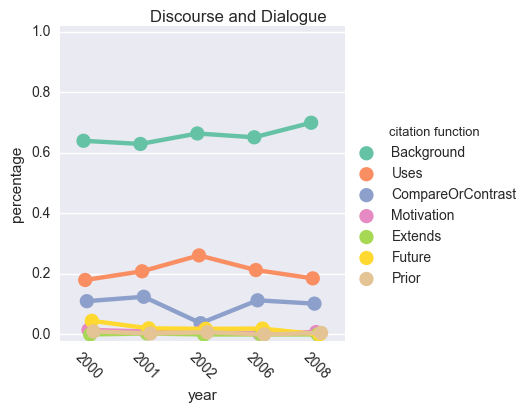

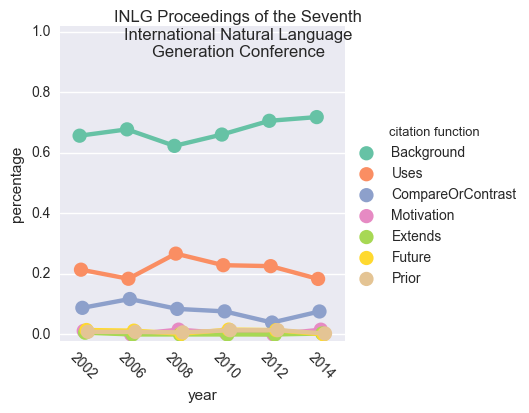

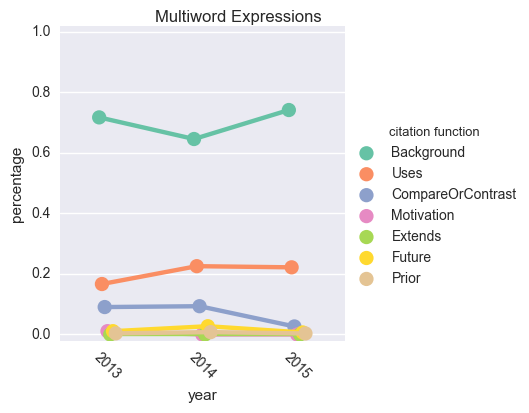

In [36]:
workshops = set(workshop_how_citing_df['workshop'])
#workshops = ['Reordering for Statistical Machine Translation']

for w in workshops:
    w_df = workshop_how_citing_df[workshop_how_citing_df['workshop'] == w]
    #print w_df.head()
    g = sns.factorplot(x="year", y="percentage", title=w, data=w_df, ci=None,
                       hue_order=['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future', 'Prior'],
                       hue='citation function', dodge=True, palette='Set2')
    g.fig.suptitle(textwrap.fill(w, 40).decode('utf-8'))
    g.set_xticklabels(rotation=-45)
    plt.ylim(-0.02, 1.02)
    #break

# The code below attempts to automatically canonicalize a workshop across all its ACL venue prefixes (e.g., W01-01)

In [3]:
names_df = []
for year in range(1977, 2018):
    year = year % 100
    page = 'http://aclweb.org/anthology/W/W%02d/' % year
    #print page
    #page = 'http://aclweb.org/anthology/W/W01/'
    r = urllib.urlopen(page).read()
    soup = BeautifulSoup(r, "html.parser")
    links = soup.find_all("a")
    for link in links:
        #print link
        try:
            href = link["href"]
        except:
            continue
        text = link.get_text()
        if len(href) == 5:
            key = 'W%02d-%s' % (year, href[1:3])
            orig_text = text
            i = text.find('Workshop on ')
            if i > 0:
                text = text[i + len('Workshop on '):]
            text = re.sub(r' [0-9]{4}', '', text)
            print text, ' -> ', key
            names_df.append({'name': orig_text, 'cleaned name': text, 'prefix': key})
names_df = pd.DataFrame(names_df)
names_df.to_csv('../data/workshop-names.tsv', sep='\t', index=False, encoding='utf-8')

Natural Language Generation  ->  W90-01
Tree Adjoining Grammar and Related Frameworks (TAG+1)  ->  W90-02
Reversible Grammar in Natural Language Processing  ->  W91-01
Lexical Semantics and Knowledge Representation  ->  W91-02
Proceedings of the 8th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W91-03
Acquisition of Lexical Knowledge from Text  ->  W93-01
Intentionality and Structure in Discourse Relations  ->  W93-02
VERY LARGE CORPORA: ACADEMIC AND INDUSTRIAL PERSPECTIVES  ->  W93-03
Proceedings of the 9th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W93-04
The Balancing Act: Combining Symbolic and Statistical Approaches to Language  ->  W94-01
Computational Phonology  ->  W94-02
Natural Language Generation  ->  W94-03
Very Large Corpora  ->  W95-01
Proceedings of the 10th Nordic Conference of Computational Linguistics (NODALIDA)  ->  W95-02
Very Large Corpora  ->  W96-01
Conference on Empirical Methods in Natural Language Processing  ->  W96-02
Bre

In [12]:
names_df = pd.read_csv('../data/workshop-names.tsv', sep='\t')

In [13]:
names_df.head()
len(names_df)

745

In [14]:
print names_df.groupby('cleaned name')

#len(names_df.groupby('cleaned name'))

In [15]:
names = names_df['cleaned name']

#def lev_metric(x, y):
#    i, j = int(x[0]), int(y[0])     # extract indices
#    return levenshtein(names[i], names[j])

#X = np.arange(len(names)).reshape(-1, 1)
#fit = dbscan(X, metric=lev_metric, eps=5, min_samples=1)

In [16]:
#print fit
all_names = list(set(names))
clusters = []
unmatched = []
used = set()

for i, name in enumerate(all_names):
    if i in used:
        continue
    used.add(name)
    cluster = [ name ]
    for j, name2 in enumerate(all_names[i+1:]):
        if name2 in used:
            continue
        ratio = fuzz.ratio(name, name2)
        tr = fuzz.token_set_ratio(name, name2)
        if ratio > 80 and tr > 70:
            if 'Statistical Machine Translation' in name or 'Statistical Machine Translation' in name2:
                print name, name2, ratio, tr
            used.add(name2)
            cluster.append(name2)
    if len(cluster) > 1:
        clusters.append(cluster)
    else:
        unmatched.extend(cluster)

Reordering for Statistical Machine Translation Statistical Machine Translation 81 100
Semantics-Driven Statistical Machine Translation (S2MT) Semantics-Driven Machine Translation (SedMT) 85 92


In [17]:
sorted_clusters = sorted(clusters, reverse=True, key=len)
for cluster in sorted_clusters:
    for c in cluster:
        if 'Semantics-Driven Statistical Machine Translation' in c:
            print cluster

['Semantics-Driven Statistical Machine Translation (S2MT)', 'Semantics-Driven Machine Translation (SedMT)']


In [18]:
name_to_prefixes = defaultdict(set)
for row in names_df.itertuples():
    name_to_prefixes[row[1]].add(row[3])

In [19]:
for u in unmatched:
    if 'Named Entities' in u:
        print u

Proceedings of the Named Entities Workshop: Shared Task on Transliteration (NEWS)
Proceedings of the 3rd Named Entities Workshop (NEWS)


In [20]:
print len(name_to_prefixes)
print name_to_prefixes['Semantics-Driven Machine Translation (SedMT)']
#print name_to_prefixes

630
set(['W16-06'])


In [21]:
sorted_clusters = sorted(clusters, reverse=True, key=len)

In [22]:
workshop_to_prefixes = defaultdict(list)
prefix_to_workshop = {}

for cluster in sorted_clusters:
    prefixes = []
    for c in cluster:
        prefixes.extend(name_to_prefixes[c])
    if len(prefixes) >= 5:
        workshop_to_prefixes[cluster[0]].extend(prefixes)

for c in unmatched:
    prefixes = name_to_prefixes[c]
    if len(prefixes) >= 5:
        workshop_to_prefixes[c].extend(prefixes)
        
        
for w, ps in workshop_to_prefixes.iteritems():
    for p in ps:
        prefix_to_workshop[p] = w

        
print len(workshop_to_prefixes)
        
for i, (name, years) in enumerate(workshop_to_prefixes.iteritems()):
    print name, '->', '\n'.join(years)
    print ''

32
Innovative Use of NLP for Building Educational Applications -> W13-17
W15-06
W10-10
W16-05
W14-18
W08-09
W09-21
W11-14

Proceedings of the Named Entities Workshop -> W10-24
W12-44
W15-39
W11-32
W16-27

Proceedings of the 11th Linguistic Annotation Workshop -> W17-08
W14-49
W09-30
W11-04
W10-18
W12-36
W15-16
W07-15

Reordering for Statistical Machine Translation -> W12-59
W13-22
W06-31
W12-31
W14-33
W11-21
W09-04
W07-07
W08-03
W15-30

Natural Language Generation (ENLG) -> W15-47
W09-06
W05-16
W94-03
W13-21
W11-28
W98-14
W90-01
W07-23
W03-23
W01-08

Tree Adjoining Grammar and Related Frameworks (TAG+6) -> W02-22
W04-33
W06-15
W12-46
W10-44
W00-20
W90-02
W08-23
W16-33
W98-01

Conference on Empirical Methods in Natural Language Processing -> W96-02
W04-32
W03-10
W06-16
W01-05
W97-03
W02-10

Cognitive Aspects of the Lexicon (COGALEX) -> W08-19
W10-34
W12-51
W16-53
W14-47

Proceedings of the Tenth Conference on Computational Natural Language Learning (CoNLL-X) -> W06-29
W10-29
W14-17
W08-

In [36]:
workshop_to_prefixes = defaultdict(list)
prefix_to_workshop = {}

for cluster in sorted_clusters:
    prefixes = []
    for c in cluster:
        prefixes.extend(name_to_prefixes[c])
    #if len(prefixes) >= 5:
    workshop_to_prefixes[cluster[0]].extend(prefixes)

for c in unmatched:
    prefixes = name_to_prefixes[c]
    #if len(prefixes) >= 5:
    workshop_to_prefixes[c].extend(prefixes)       
        
for w, ps in workshop_to_prefixes.iteritems():
    for p in ps:
        prefix_to_workshop[p] = w

        
#print len(workshop_to_prefixes)
        
for i, (name, years) in enumerate(workshop_to_prefixes.iteritems()):
    if len(years) == 0:
        continue
    print str(len(years)) + ';' + name + ';' + ';'.join(years)

1;Definition Extraction;W09-44
11;Natural Language Generation (ENLG);W15-47;W09-06;W05-16;W94-03;W13-21;W11-28;W98-14;W90-01;W07-23;W03-23;W01-08
1;NLP and Linguistics: Finding the Common Ground;W10-21
1;Partially Automated Techniques for Transcribing Naturally Occurring Continuous Speech;W98-08
1;Cross Lingual Information Access: Addressing the Information Need of Multilingual Societies (CLIAWS3);W09-16
1;Integer Linear Programming for Natural Language Processing;W09-18
1;ROMAND:Robust Methods in Analysis of Natural language Data;W06-23
2;Software Engineering, Testing, and Quality Assurance for Natural Language Processing;W08-05;W09-15
1;Multiword Expressions: Analysis, Acquisition and Treatment;W03-18
14;Proceedings of the Tenth Conference on Computational Natural Language Learning (CoNLL-X);W06-29;W10-29;W14-17;W08-21;W14-16;W13-35;W04-24;W11-03;W10-30;W09-12;W09-11;W05-06;W11-19;W13-36
1;Lexical Semantics and Knowledge Representation;W91-02
3;Predicting and Improving Text Readabili